# Temperature and pressure acquisition

## Acquisition functions

In [27]:
from __future__ import print_function
import csv
from time import sleep
from sys import stdout
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from daqhats import mcc128, OptionFlags, mcc134, HatIDs, HatError, TcTypes, AnalogInputMode, AnalogInputRange
from daqhats_utils import select_hat_device, tc_type_to_string, \
enum_mask_to_string, input_mode_to_string, input_range_to_string #This needs to be in the same folders as this script



def volt_to_bar(volt_value, slope=50, offset=0):
    """
    Converts a voltage value to a bar value using linear conversion.

    Args:
        volt_value (float): The voltage value to convert.
        slope (float, optional): The slope coefficient for the linear conversion. Defaults to 50.
        offset (float, optional): The offset coefficient for the linear conversion. Defaults to 0.

    Returns:
        float: The bar value converted from the voltage value.
    """
    # Apply linear conversion formula: bar_value = volt_value * slope + offset
    bar_value = volt_value * slope + offset

    return bar_value



def T_P_acq_csv(channels_134=(0, 1), channels_128=(0, 1), acq_frequency=1, N_measures=10, terminal_output=True,
                data_filename="data.csv"):
    """
    Acquires Pressure and Temperature data before and after microchip and writes it to a CSV file.

    Args:
        channels_134 (tuple, optional): Sensors channels on MC134. Defaults to (0, 1).
        channels_128 (tuple, optional): Sensors channels on MC128. Defaults to (0, 1).
        acq_frequency (int, optional): Acquisition frequency in Hz. Defaults to 1.
        N_measures (int, optional): Number of measures. Defaults to 10.
        terminal_output (bool, optional): Whether to display terminal output. Defaults to True.
        data_filename (str, optional): Name of the data CSV file. Defaults to "data.csv".
    """
    import datetime

    try:
        # Initialisation of MC128
        address = select_hat_device(HatIDs.MCC_128)
        hat_128 = mcc128(address)
        input_mode = AnalogInputMode.SE
        input_range = AnalogInputRange.BIP_5V
        hat_128.a_in_mode_write(input_mode)
        hat_128.a_in_range_write(input_range)

        # Initialisation of MC134
        address_134 = select_hat_device(HatIDs.MCC_134)
        hat_134 = mcc134(address_134)
        tc_type = TcTypes.TYPE_K

        # Initialisation of P and T data arrays
        T_array = np.zeros((N_measures, len(channels_134)))
        P_array = np.zeros((N_measures, len(channels_128)))

        current_datetime = datetime.datetime.now()
        formatted_datetime = current_datetime.strftime("%Y-%m-%d %H:%M:%S")

        delay_between_reads = 1 / acq_frequency

        with open(data_filename, mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["Date and time", formatted_datetime, "Number of measures: ", N_measures,
                             "Acquisition frequency: ", acq_frequency, "Hz"])
            writer.writerow(["N_measure", "Pressure 1", "Temperature 1", "Pressure 2", "Temperature 2"])

            if terminal_output:
                print('\nAcquiring data ... Press Ctrl-C to abort')
                print('\nNumber of measures:', N_measures, 'Acquisition frequency:', acq_frequency, 'Hz')
                print('\nDate and time:', formatted_datetime)
                print('\n  Sample', end='')
                for channel in channels_128:
                    print('     Channel Temperature', channel, end='')
                for channel in channels_134:
                    print('     Channel Pressure', channel, end='')
                print('')

            samples_per_channel = 0

            for i in range(N_measures):
                samples_per_channel += 1
                if terminal_output:
                    print('\r{:8d}'.format(samples_per_channel), end='')

                for channel in channels_134:
                    hat_134.tc_type_write(channel, tc_type)
                    value_T = hat_134.t_in_read(channel)
                    T_array[i, channel] = value_T

                    if terminal_output:
                        if value_T == mcc134.OPEN_TC_VALUE:
                            print('     Open     ', end='')
                        elif value_T == mcc134.OVERRANGE_TC_VALUE:
                            print('     OverRange', end='')
                        elif value_T == mcc134.COMMON_MODE_TC_VALUE:
                            print('   Common Mode', end='')
                        else:
                            print('{:12.2f} C'.format(value_T), end='')

                for channel in channels_128:
                    value_P_volt = hat_128.a_in_read(channel)
                    value_P_bar = volt_to_bar(value_P_volt)
                    P_array[i, channel] = value_P_bar

                    if terminal_output:
                        print('{:12.2f} bar'.format(value_P_bar), end='')

                stdout.flush()
                sleep(delay_between_reads)

                row = [i, P_array[i, 0], T_array[i, 0], P_array[i, 1], T_array[i, 1]]
                writer.writerow(row)

    except (HatError, ValueError) as error:
        print('\n', error)
        


def T_P_disp(channels_134=(0, 1), channels_128=(0, 1), delay_between_reads=0.1):
    """
    Displays real-time Temperature and Pressure data from sensors on MC134 and MC128.

    Args:
        channels_134 (tuple, optional): Sensors channels on MC134. Defaults to (0, 1).
        channels_128 (tuple, optional): Sensors channels on MC128. Defaults to (0, 1).
        delay_between_reads (float, optional): Delay between sensor readings in seconds. Defaults to 0.1.
    """
    import datetime

    try:
        # Initialisation of MC128
        address = select_hat_device(HatIDs.MCC_128)
        hat_128 = mcc128(address)
        input_mode = AnalogInputMode.SE
        input_range = AnalogInputRange.BIP_5V
        hat_128.a_in_mode_write(input_mode)
        hat_128.a_in_range_write(input_range)

        # Initialisation of MC134
        address_134 = select_hat_device(HatIDs.MCC_134)
        hat_134 = mcc134(address_134)
        tc_type = TcTypes.TYPE_K

        current_datetime = datetime.datetime.now()
        formatted_datetime = current_datetime.strftime("%Y-%m-%d %H:%M:%S")

        for channel in channels_134:
            hat_134.tc_type_write(channel, tc_type)

        # Display the header row for the data table.
        for channel in channels_128:
            print('     Channel Temperature', channel, end='')
        for channel in channels_134:
            print('     Channel Pressure', channel, end='')
        print('')

        while True:
            for channel in channels_134:
                value_T = hat_134.t_in_read(channel)

                if value_T == mcc134.OPEN_TC_VALUE:
                    print('     Open     ', end='')
                elif value_T == mcc134.OVERRANGE_TC_VALUE:
                    print('     OverRange', end='')
                elif value_T == mcc134.COMMON_MODE_TC_VALUE:
                    print('   Common Mode', end='')
                else:
                    print('{:12.2f} C'.format(value_T), end='')

            for channel in channels_128:
                value_P_volt = hat_128.a_in_read(channel)
                value_P_bar = volt_to_bar(value_P_volt)
                
                #This is here in order to print continuously T and P values over the same line
                if channel == channels_128[-1]:
                    print('{:12.2f} bar'.format(value_P_bar), end='\r')
                else:
                    print('{:12.2f} bar'.format(value_P_bar), end='')

            stdout.flush()
            sleep(delay_between_reads)

    except (HatError, ValueError) as error:
        print('\n', error)
        
        
        

        
def csv_data_reader(file_name = "data.csv", terminal_output = False):
    # Specify the path to the CSV file
    csv_file = file_name

    # Initialize empty arrays for acquisition parameters, headers, and data
    acquisition_params = []
    column_headers = []
    data = []

    # Read the CSV file
    with open(csv_file, "r") as file:
        reader = csv.reader(file)

        # Extract the acquisition parameters from the first line
        acquisition_params = next(reader)

        # Extract the headers from the second line
        column_headers = next(reader)

        # Read the rest of the lines as data
        data = list(reader)
    
    if terminal_output:
        # Print the arrays if terminal_output == True
        print("Acquisition Parameters:", acquisition_params)
        print("Column Headers:", column_headers)
        print("Data:")
        for row in data:
            print(row)

    return acquisition_params, column_headers, np.array(data)


## Trigger acquisition

In [5]:
import RPi.GPIO as GPIO

# Set the GPIO mode to BCM
GPIO.setmode(GPIO.BCM)

# Define the GPIO pin number
trigger_pin = 17

# Set up the GPIO pin as an input with an initial high state
GPIO.setup(trigger_pin, GPIO.IN, pull_up_down=GPIO.PUD_UP)

def trigger_callback(channel):
    """
    Callback function to be executed when the trigger input is detected.

    Args:
        channel (int): The GPIO channel number that triggered the callback.
    """
    print("Acquiring temperature and pressure data in csv...")
    T_P_acq_csv(channels_134=(0, 1), channels_128=(0, 1), acq_frequency=10, N_measures=50, terminal_output=False, data_filename="data.csv")
    print("Data saved in csv!")

# Add the event detection for the falling edge of the trigger input
GPIO.add_event_detect(trigger_pin, GPIO.FALLING, callback=trigger_callback)

try:
    print("Waiting for trigger input...")
    while True:
        T_P_disp(channels_134=(0, 1), channels_128=(0, 1), delay_between_reads=1)

except KeyboardInterrupt:
    print("Exiting...")
    GPIO.cleanup()
    


Waiting for trigger input...
     Channel Temperature 0     Channel Temperature 1     Channel Pressure 0     Channel Pressure 1
Acquiring temperature and pressure data in csv...  -0.04 bar
Data saved in csv!   23.42 C       -5.41 bar       -0.04 bar
Acquiring temperature and pressure data in csv...
Data saved in csv!   23.44 C       -5.68 bar       -0.03 bar
Acquiring temperature and pressure data in csv...  -0.04 bar
Data saved in csv!   23.50 C       -4.94 bar       -0.03 bar
Acquiring temperature and pressure data in csv...
Data saved in csv!   23.63 C       -5.15 bar       -0.02 bar
Exiting...44 C       23.16 C       -5.41 bar       -0.03 bar


## Manual acquisition

In [39]:
T_P_acq_csv(channels_134 = (0, 1), channels_128 = (0, 1), acq_frequency = 100, N_measures = 200, terminal_output = True, data_filename = "data.csv")



Acquiring data ... Press Ctrl-C to abort

Number of measures: 200 Acquisition frequency: 100 Hz

Date and time: 2023-05-19 16:04:31

  Sample     Channel Temperature 0     Channel Temperature 1     Channel Pressure 0     Channel Pressure 1
     200       23.27 C       23.09 C       -6.15 bar       -0.04 bar       -6.04 bar       -0.04 bar       -0.04 bar       23.16 C       -5.93 bar       -0.03 bar       23.16 C       -6.17 bar       -0.04 bar       23.16 C       -5.59 bar       -0.04 bar       -6.21 bar       -0.04 bar       23.35 C       23.16 C       -5.95 bar       -0.04 bar       23.35 C       23.16 C       -5.86 bar       -0.04 bar       23.16 C       -6.24 bar       -0.04 bar       23.16 C       -6.21 bar       -0.04 bar       23.31 C       23.12 C       -6.18 bar       -0.03 bar       23.12 C       -5.67 bar       -0.04 bar       23.12 C       -6.14 bar       -0.04 bar       -6.22 bar       -0.04 bar       23.12 C       -6.11 bar       -0.03 bar       23.31 C       23.12 C   

In [40]:
acquisition_params, column_headers, data = csv_data_reader(file_name = "data.csv", terminal_output = False)

In [37]:
column_headers

['N_measure', 'Pressure 1', 'Temperature 1', 'Pressure 2', 'Temperature 2']

## Plotting the data

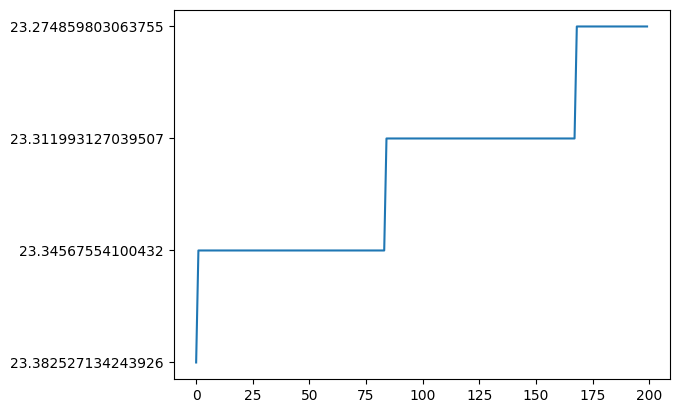

In [41]:
plt.plot(data[:,2])

In [42]:
data[0,2]

'23.382527134243926'